<a href="https://colab.research.google.com/github/gabrielbarbascu/gabrielbarbascu/blob/main/Copy_of_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Binary Image Classification (Cats vs. Dogs)**

Member 1: Gabriel, Barbascu

Member 2: Laila, Lamnouar

Member 3: Martin, Abaskharoun

Member 4: Horia-Rares, Vulcu

Member 5: Amin, Moamen Tarek



Gabriel, Barbascu: Dataset & Preprocessing Lead

# Gabriel, Barbascu: Dataset & Preprocessing Lead

In [ ]:
!pip install onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%writefile utils.py
import os
import time
import random
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_training_metrics(losses, accuracies, val_accuracies):
    epochs_range = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, label='Training Accuracy')
    plt.plot([i for i in epochs_range if (i-1) % 1 == 0], val_accuracies, label='Validation Accuracy', linestyle='--') # Corrected indexing

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def show_colored_random_samples(dataset, classes, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Convert tensor to numpy array for displaying
        # Denormalize and transpose for matplotlib
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f'Class: {classes[label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def get_random_samples(dataset, num_samples=1):
    indices = random.sample(range(len(dataset)), num_samples)
    samples_X = []
    samples_y = []
    for i in indices:
        X, y = dataset[i]
        samples_X.append(X)
        samples_y.append(y)
    return samples_X, samples_y

def plot_score_distribution(prediction_scores, true_labels, classes, threshold=0.5):
    scores = np.array(prediction_scores).flatten()
    labels = np.array(true_labels).flatten()

    # Separate scores by true label
    cat_scores = scores[labels == 1]
    dog_scores = scores[labels == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(dog_scores, bins=50, alpha=0.5, label=f'True {classes[0]} Scores', color='blue')
    plt.hist(cat_scores, bins=50, alpha=0.5, label=f'True {classes[1]} Scores', color='red')
    plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold:.2f}')
    plt.title('Distribution of Prediction Scores by True Class')
    plt.xlabel('Predicted Probability of being a Cat')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

def plot_sensitivity_specificity_vs_thresholds(thresholds, tpr, fpr):
    # Calculate specificity (1 - FPR)
    specificity = 1 - fpr

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr, label='Sensitivity (True Positive Rate)')
    plt.plot(thresholds, specificity, label='Specificity (True Negative Rate)')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Sensitivity and Specificity vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find the threshold that maximizes (sensitivity + specificity)
    optimal_idx = np.argmax(tpr + specificity)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal Threshold: {optimal_threshold:.4f} (Maximizes Sensitivity + Specificity)")

    return optimal_threshold

def plot_roc_curve(true_labels, prediction_scores):
    fpr, tpr, thresholds = roc_curve(true_labels, prediction_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return fpr, tpr, thresholds

def save_checkpoint(model, epoch, directory='./checkpoints', checkpoint_dir=None):
    """
    Saves the model checkpoint to the specified directory.

    Args:
        model (torch.nn.Module): The model to save.
        epoch (int): The current epoch number.
        directory (str): Default local directory for checkpoints if checkpoint_dir is None.
        checkpoint_dir (str, optional): The new Google Drive path to save checkpoints.
                                        Takes precedence over 'directory' if provided.
    """
    target_dir = checkpoint_dir if checkpoint_dir is not None else directory

    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)

    checkpoint_path = os.path.join(target_dir, f'model_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict()
        # You might want to save optimizer state, loss, etc. here too
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_nearest_checkpoint(model, start_epoch, directory='./checkpoints', checkpoint_dir=None):
    """
    Loads the nearest checkpoint to the specified start_epoch.

    Args:
        model (torch.nn.Module): The model to load the checkpoint into.
        start_epoch (int): The starting epoch to look for (will load the nearest available before or at this epoch).
        directory (str): Default local directory for checkpoints if checkpoint_dir is None.
        checkpoint_dir (str, optional): The new Google Drive path to load checkpoints from.
                                        Takes precedence over 'directory' if provided.
    """
    target_dir = checkpoint_dir if checkpoint_dir is not None else directory

    if not os.path.exists(target_dir):
        print(f"Checkpoint directory '{target_dir}' does not exist. No checkpoint loaded.")
        return 0 # Return 0 if no directory exists

    checkpoints = []
    for f in os.listdir(target_dir):
        match = re.match(r'model_epoch_(\d+)\.pth', f) # Fix: Corrected regex to match literal dot
        if match:
            epoch = int(match.group(1))
            checkpoints.append((epoch, os.path.join(target_dir, f)))

    if not checkpoints:
        print(f"No checkpoints found in '{target_dir}'. Starting from scratch.")
        return 0 # Return 0 if no checkpoints found

    # Find the checkpoint with the numerically largest epoch number less than or equal to start_epoch
    checkpoints.sort(key=lambda x: x[0], reverse=True)
    best_checkpoint_path = None
    loaded_epoch = 0 # Initialize loaded_epoch

    for epoch, path in checkpoints:
        if epoch <= start_epoch:
            best_checkpoint_path = path
            loaded_epoch = epoch
            break

    if best_checkpoint_path:
        print(f"Loading checkpoint from {best_checkpoint_path}")
        checkpoint = torch.load(best_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint loaded: Epoch {checkpoint['epoch']}")
        return checkpoint['epoch'] # Return the loaded epoch
    else:
        print(f"No checkpoint found before or at epoch {start_epoch} in '{target_dir}'. Starting from scratch.")
        return 0 # Return 0 if no checkpoint is loaded

def remove_corrupted_images(path):
    for filename in os.listdir(path):
        if filename.endswith('.jpg'):
            filepath = os.path.join(path, filename)
            try:
                img = Image.open(filepath)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupted file detected and removed: {filepath}")
                os.remove(filepath)

def save_training_data(filepath, hyperparams, losses, accuracies, val_accuracies):
    training_data = {
        'hyperparameters': hyperparams,
        'losses': losses,
        'accuracies': accuracies,
        'val_accuracies': val_accuracies
    }
    with open(filepath, 'w') as f:
        json.dump(training_data, f, indent=4)
    print(f"Training data saved to {filepath}")

def load_training_data(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            training_data = json.load(f)
        print(f"Training data loaded from {filepath}")
        return training_data
    else:
        print(f"No training data found at {filepath}")
        return None

def plot_training_data(all_training_data):
    if not all_training_data: return

    losses = all_training_data['losses']
    accuracies = all_training_data['accuracies']
    val_accuracies = all_training_data['val_accuracies']
    hyperparams = all_training_data['hyperparameters']

    plot_training_metrics(losses, accuracies, val_accuracies)

    print("\nHyperparameters:")
    for key, value in hyperparams.items():
        print(f"  {key}: {value}")

Writing utils.py


In [ ]:
import os
import time
import random
import warnings
import shutil
import utils

# Data processing and modelization
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset # Import Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix  # Avoid duplicate imports
import kagglehub

# Monitoring and visualization
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import graphviz

# Various utilities
from utils import (
    plot_confusion_matrix,
    plot_training_metrics,
    show_colored_random_samples,
    get_random_samples,
    plot_score_distribution,
    plot_sensitivity_specificity_vs_thresholds,
    plot_roc_curve,
    save_checkpoint,
    load_nearest_checkpoint,
    remove_corrupted_images,
    save_training_data,
    load_training_data,
    plot_training_data
)

# Model export and loading
import onnx
import onnxruntime as ort

warnings.filterwarnings('ignore')

graphviz.set_jupyter_format('png')

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    device = 'cuda'
    torch.cuda.get_device_name(0)
    # Removed: torch.set_default_tensor_type(torch.FloatTensor) to avoid global tensor type changes
    print(f'CUDA is available. Training on {torch.cuda.get_device_name()}')
else:
    device = 'cpu'
    print('CUDA is not available. Training on CPU')

# The generator object is defined but will not be passed explicitly to DataLoader
# for num_workers > 0, to avoid device conflicts.
generator = torch.Generator(device='cpu')

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
# Set the environment variable for deterministic behavior
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

if train_on_gpu:
    torch.cuda.manual_seed_all(SEED)


path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
dogs_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Dog")
cats_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Cat")
# path

try:
    remove_corrupted_images(dogs_path)
except OSError as e:
    print(f"Warning: Could not remove corrupted images from {dogs_path} due to: {e}. "
          f"This might happen in read-only file systems. Non-.jpg files are typically filtered out later.")
try:
    remove_corrupted_images(cats_path)
except OSError as e:
    print(f"Warning: Could not remove corrupted images from {cats_path} due to: {e}. "
          f"This might happen in read-only file systems. Non-.jpg files are typically filtered out later.")

# Until now it was the initialization, now the processing

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),                     # Resize to target size
    transforms.RandomHorizontalFlip(),                 # Randomly flip the image horizontally for data augmentation
    transforms.RandomRotation(degrees=15),             # Randomly rotate image by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation
    transforms.ToTensor(),                             # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize colors
])

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset params
TOTAL_SAMPLES = 24000
TRAIN_SIZE = 0.925
VAL_SIZE = 0.025
TEST_SIZE = 0.05
BATCH_SIZE = 64

# Get the required number of samples for each class
dog_images = [os.path.join(dogs_path, img) for img in os.listdir(dogs_path) if img.endswith(".jpg")][:(TOTAL_SAMPLES // 2)]
cat_images = [os.path.join(cats_path, img) for img in os.listdir(cats_path) if img.endswith(".jpg")][:(TOTAL_SAMPLES // 2)]

# Associate the images with their labels
all_images = dog_images + cat_images
all_labels = [0] * len(dog_images) + [1] * len(cat_images)

# Divide into 3 subsets (train, val, test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=(1 - TRAIN_SIZE), stratify=all_labels, random_state=42
)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), stratify=temp_labels, random_state=42
)

# personnalized Dataset to deal with images and their labels
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

train_dataset = CatDogDataset(train_imgs, train_labels, transform=train_transforms)
val_dataset = CatDogDataset(val_imgs, val_labels, transform=data_transform)
test_dataset = CatDogDataset(test_imgs, test_labels, transform=data_transform)

# Use Subset to correctly select a range of samples
train_subset_indices = list(range(len(train_dataset)))[:5000] # Take first 10 for demonstration
train_subset_dataset = Subset(train_dataset, train_subset_indices)

train_loader = DataLoader(
    train_subset_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True

)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False

)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False

)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")


CUDA is available. Training on Tesla T4
Using Colab cache for faster access to the 'kaggle-cat-vs-dog-dataset' dataset.
Number of training samples: 5000
Number of validation samples: 600
Number of test samples: 1200


In [ ]:
warnings.filterwarnings('ignore')

graphviz.set_jupyter_format('png')

'png'

In [ ]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    device = 'cuda'
    torch.cuda.get_device_name(0)
    print(f'CUDA is available. Training on {torch.cuda.get_device_name()}')
else:
    device = 'cpu'
    print('CUDA is not available. Training on CPU')
# For DataLoader sampling, it's generally safer to use a CPU generator when num_workers > 0
generator = torch.Generator(device='cpu')


CUDA is available. Training on Tesla T4


In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
# Set the environment variable for deterministic behavior
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"

if train_on_gpu:
    torch.cuda.manual_seed_all(SEED)

In [ ]:
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
dogs_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Dog")
cats_path = os.path.join(path, "kagglecatsanddogs_3367a/PetImages/Cat")
path

Using Colab cache for faster access to the 'kaggle-cat-vs-dog-dataset' dataset.


'/kaggle/input/kaggle-cat-vs-dog-dataset'

In [ ]:
try:
    remove_corrupted_images(dogs_path)
except OSError as e:
    print(f"Warning: Could not remove corrupted images from {dogs_path} due to: {e}. "
          f"This might happen in read-only file systems. Non-.jpg files are typically filtered out later.")
try:
    remove_corrupted_images(cats_path)
except OSError as e:
    print(f"Warning: Could not remove corrupted images from {cats_path} due to: {e}. "
          f"This might happen in read-only file systems. Non-.jpg files are typically filtered out later.")

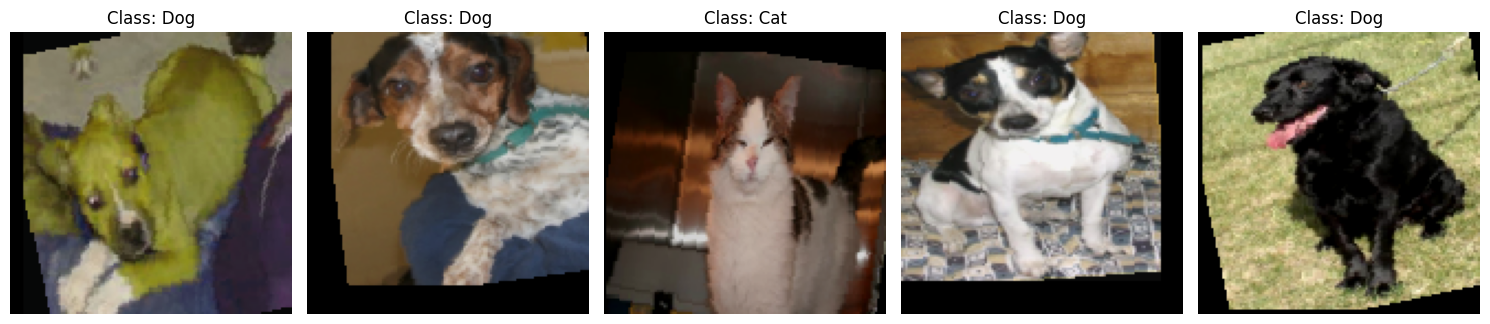

In [ ]:
classes = ["Dog", "Cat"]
show_colored_random_samples(train_dataset, classes)

# Martin, Abaskharoun: Model Design & Implementation Lead

In [ ]:
class CNNBinaryClassifier(nn.Module):
    def __init__(self, input_shape=(3, 128, 128)):
        super(CNNBinaryClassifier, self).__init__()

        # Convolutional Block 1
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)  # BatchNorm after last conv in block
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling by 2

        # Convolutional Block 2
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 4 (with an additional convolutional layer)
        self.conv4_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Extra layer
        self.bnorm4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output (1, 1) spatially for each channel

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bnorm1(x)
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bnorm2(x)
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bnorm3(x)
        x = self.pool3(x)

        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))  # Additional layer
        x = self.bnorm4(x)
        x = self.pool4(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # Flatten for fully connected layers

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Binary classification output

        return x

summary(CNNBinaryClassifier().to(device), input_size = [(3, 128, 128)], device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
            Conv2d-2         [-1, 32, 128, 128]           9,248
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10          [-1, 128, 32, 32]         147,584
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
           Conv2d-14          [-1, 256,

In [ ]:
def validate_model(model, val_loader, threshold = 0.5):
    """
    Validate the model using a validation data loader and calculate accuracy and confusion matrix.

    Parameters:
    model (torch.nn.Module): The PyTorch model to validate.
    val_loader (torch.utils.data.DataLoader): The validation data loader.
    threshold (float, optional): The threshold to convert probabilities to binary predictions.
                                Defaults to 0.5.

    Returns:
    tuple: A tuple containing the accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            preds = (outputs > threshold).float()

            all_preds.extend(preds.detach().cpu().numpy().flatten())
            all_labels.extend(labels.detach().cpu().numpy().flatten())

    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    if len(all_preds) != len(all_labels):
        raise ValueError(f"Found input variables with inconsistent numbers of samples: [{len(all_preds)}, {len(all_labels)}]")

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Laila, Lamnouar: Training & Experiments Lead

In [ ]:
EPOCHS = 100 #250 # 1000
LEARNING_RATE = 0.0001
VALIDATION_EPOCH_INTERVAL = 1
CHECKPOINT_EPOCH_INTERVAL = 1
STARTING_EPOCH = 100 # Temporarily set to 0 to regenerate full history
EARLY_STOPPING_ACC_THRESHOLD = 0.975  # Accuracy threshold (example: 90%)
EARLY_STOPPING_PATIENCE = 1    # Number of consecutive validations above the threshold to stop
CHECKPOINT_DIR = "/content/checkpoints"

model = CNNBinaryClassifier(input_shape=(3, 128, 128))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

if train_on_gpu:
    model = model.cuda()

Attempting to load checkpoint for start_epoch: 100
Checkpoint directory '/content/checkpoints' does not exist. No checkpoint loaded.
No checkpoint loaded, starting training from scratch.
Epoch [1/100], Loss: 0.661517, Accuracy: 60.36%, Val accuracy: 61.17%, Epoch time: 26.37s
Checkpoint saved to /content/checkpoints/model_epoch_1.pth
Epoch [2/100], Loss: 0.662073, Accuracy: 60.68%, Val accuracy: 60.50%, Epoch time: 26.01s
Checkpoint saved to /content/checkpoints/model_epoch_2.pth
Epoch [3/100], Loss: 0.649148, Accuracy: 62.38%, Val accuracy: 59.33%, Epoch time: 26.59s
Checkpoint saved to /content/checkpoints/model_epoch_3.pth
Epoch [4/100], Loss: 0.638800, Accuracy: 63.04%, Val accuracy: 65.67%, Epoch time: 26.26s
Checkpoint saved to /content/checkpoints/model_epoch_4.pth
Epoch [5/100], Loss: 0.636358, Accuracy: 63.92%, Val accuracy: 65.50%, Epoch time: 27.62s
Checkpoint saved to /content/checkpoints/model_epoch_5.pth
Epoch [6/100], Loss: 0.617920, Accuracy: 66.12%, Val accuracy: 68.50

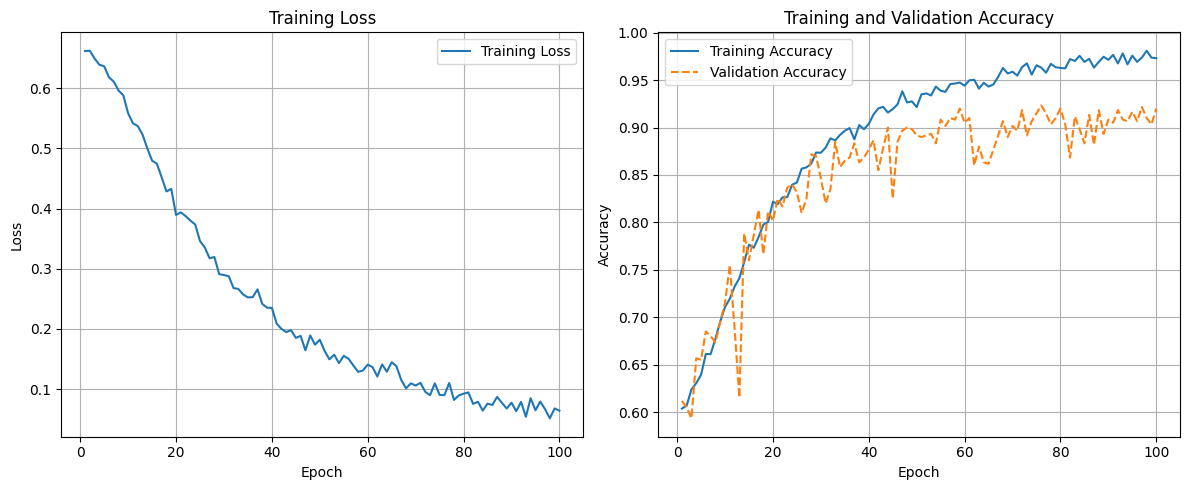

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs, start_epoch = 0):
    warnings.filterwarnings('ignore')
    model.train()

    losses = []
    accuracies = []
    val_accuracies = []

    epoch_times = []

    # Early stopping tracking variables
    best_val_accuracy = 0
    consecutive_val_success = 0  # Count of validation success

    actual_start_epoch = 0 # This will be the actual epoch to start training from

    if start_epoch > 0:
        print(f"Attempting to load checkpoint for start_epoch: {start_epoch}")
        loaded_epoch = load_nearest_checkpoint(model, start_epoch, checkpoint_dir=CHECKPOINT_DIR)
        if loaded_epoch > 0: # If a checkpoint was successfully loaded
            actual_start_epoch = loaded_epoch + 1 # Start from the next epoch
            print(f"Resuming training from epoch {actual_start_epoch}")
        else:
            print("No checkpoint loaded, starting training from scratch.")
    else:
        print("Starting training from scratch (start_epoch is 0).")

    total_start_time = time.time()

    # The training loop should start from actual_start_epoch
    for epoch in range(actual_start_epoch, epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.float()
            labels = labels.float().view(-1)

            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds.extend(outputs.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(np.round(all_preds), np.round(all_labels))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Fin de l'époque et calcul du temps écoulé
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        if (epoch) % VALIDATION_EPOCH_INTERVAL == 0:
            acc, _ = validate_model(model, val_loader)
            val_accuracies.append(acc)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.2f}%, "
                  f"Val accuracy: {acc * 100:.2f}%, Epoch time: {epoch_time:.2f}s")

            if acc >= EARLY_STOPPING_ACC_THRESHOLD:
                consecutive_val_success += 1
                if consecutive_val_success >= EARLY_STOPPING_PATIENCE:
                    print(f"Early stopping triggered after {epoch+1} epochs. Validation accuracy {acc * 100:.2f}% "
                          f"exceeded threshold for {EARLY_STOPPING_PATIENCE} consecutive intervals.")
                    break
            else:
                consecutive_val_success = 0

        else:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc * 100:.2f}%, "
                  f"Epoch time: {epoch_time:.2f}s")


        if (epoch) % CHECKPOINT_EPOCH_INTERVAL == 0 and epoch >= 0:
            save_checkpoint(model, epoch, checkpoint_dir=CHECKPOINT_DIR)

    # Temps total d'entraînement
    total_training_time = time.time() - total_start_time

    if len(epoch_times) > 0: # Only calculate average and plot if new epochs were trained
        average_epoch_time = sum(epoch_times) / len(epoch_times)
        print(f"\nTotal training time for new epochs: {total_training_time:.2f}s")
        print(f"Average time per epoch for new epochs: {average_epoch_time:.2f}s")
    else:
        print(f"\nNo new epochs were trained in this run (started from epoch {actual_start_epoch}, total epochs {epochs}).")


    return losses, accuracies, val_accuracies, total_training_time

losses, accuracies, val_accuracies, total_training_time = train_model(model, train_loader, criterion, optimizer, EPOCHS, start_epoch=STARTING_EPOCH)

In [ ]:
import os
import re

# Assuming CHECKPOINT_DIR is defined, if not, set it here
# CHECKPOINT_DIR = '/content/checkpoints'

if os.path.exists(CHECKPOINT_DIR):
    print(f"Contents of checkpoint directory '{CHECKPOINT_DIR}':")
    checkpoint_files = []
    for f in os.listdir(CHECKPOINT_DIR):
        match = re.match(r'model_epoch_(\d+)\.pth', f)
        if match:
            epoch = int(match.group(1))
            checkpoint_files.append((epoch, f))

    if checkpoint_files:
        checkpoint_files.sort(key=lambda x: x[0])
        print("Found the following model checkpoints (epoch, filename):")
        for epoch, filename in checkpoint_files:
            print(f"  Epoch {epoch}: {filename}")
        latest_epoch = checkpoint_files[-1][0]
        print(f"\nLatest checkpoint found is for Epoch {latest_epoch}")
        if latest_epoch > 100:
            print("It appears you have checkpoints saved up beyond Epoch 100.")
        elif latest_epoch==100:
            print(f"Checkpoints are saved up to Epoch 100.")
        else:
            print(f"Checkpoints are saved up to Epoch {latest_epoch}, which is less than 100.")
    else:
        print("No model checkpoints found in this directory.")
else:
    print(f"Checkpoint directory '{CHECKPOINT_DIR}' does not exist.")

Contents of checkpoint directory '/content/checkpoints':
Found the following model checkpoints (epoch, filename):
  Epoch 1: model_epoch_1.pth
  Epoch 2: model_epoch_2.pth
  Epoch 3: model_epoch_3.pth
  Epoch 4: model_epoch_4.pth
  Epoch 5: model_epoch_5.pth
  Epoch 6: model_epoch_6.pth
  Epoch 7: model_epoch_7.pth
  Epoch 8: model_epoch_8.pth
  Epoch 9: model_epoch_9.pth
  Epoch 10: model_epoch_10.pth
  Epoch 11: model_epoch_11.pth
  Epoch 12: model_epoch_12.pth
  Epoch 13: model_epoch_13.pth
  Epoch 14: model_epoch_14.pth
  Epoch 15: model_epoch_15.pth
  Epoch 16: model_epoch_16.pth
  Epoch 17: model_epoch_17.pth
  Epoch 18: model_epoch_18.pth
  Epoch 19: model_epoch_19.pth
  Epoch 20: model_epoch_20.pth
  Epoch 21: model_epoch_21.pth
  Epoch 22: model_epoch_22.pth
  Epoch 23: model_epoch_23.pth
  Epoch 24: model_epoch_24.pth
  Epoch 25: model_epoch_25.pth
  Epoch 26: model_epoch_26.pth
  Epoch 27: model_epoch_27.pth
  Epoch 28: model_epoch_28.pth
  Epoch 29: model_epoch_29.pth
  Epo

In [ ]:
hyperparams = {
    "EPOCHS": EPOCHS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "VALIDATION_EPOCH_INTERVAL": VALIDATION_EPOCH_INTERVAL,
    "CHECKPOINT_EPOCH_INTERVAL": CHECKPOINT_EPOCH_INTERVAL,
    "STARTING_EPOCH": STARTING_EPOCH,
    "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
    "SEED": SEED,
    "TRAIN_PROP": TRAIN_SIZE,
    "TRAIN_DURATION_H": total_training_time / (60**2)
}

training_logs_path = './training_data.json'

save_training_data(training_logs_path, hyperparams, losses, accuracies, val_accuracies)

Training data saved to ./training_data.json


Training data loaded from ./training_data.json


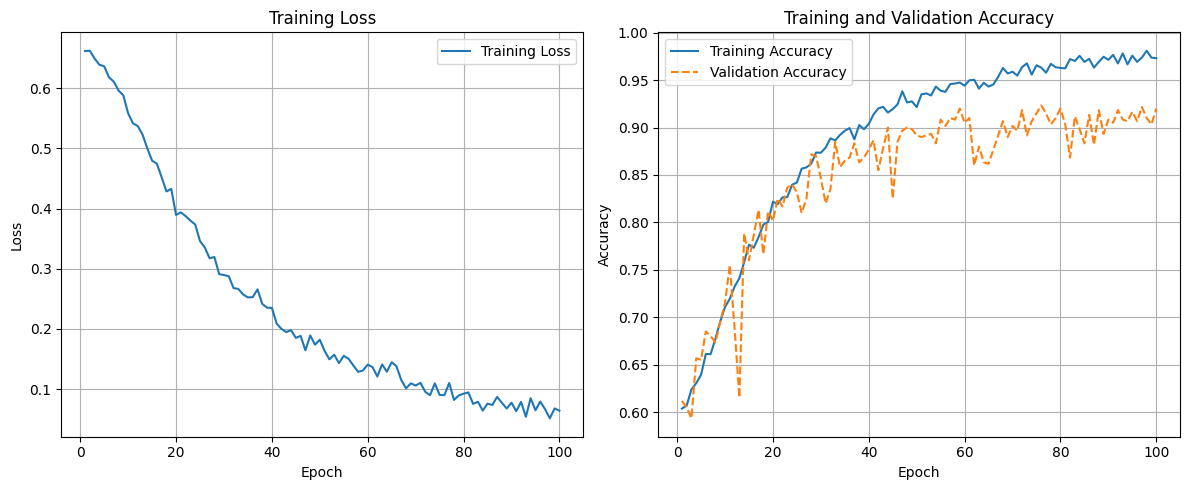


Hyperparameters:
  EPOCHS: 100
  BATCH_SIZE: 64
  LEARNING_RATE: 0.0001
  VALIDATION_EPOCH_INTERVAL: 1
  CHECKPOINT_EPOCH_INTERVAL: 1
  STARTING_EPOCH: 100
  EARLY_STOPPING_PATIENCE: 1
  SEED: 42
  TRAIN_PROP: 0.925
  TRAIN_DURATION_H: 0.79050790309906


In [ ]:
all_training_data = load_training_data(training_logs_path)

plot_training_data(all_training_data)

In [ ]:
import matplotlib.pyplot as plt

# Function to register hooks and capture outputs
def get_feature_maps(model, x, layers):
    features = []

    # Define hook function to capture the output of each layer
    def hook_fn(module, input, output):
        features.append(output.detach().cpu().numpy())

    # Register hooks for specified layers
    hooks = []
    for layer in layers:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass through the model to collect the feature maps
    with torch.no_grad():
        model(x)

    # Remove hooks after forward pass
    for hook in hooks:
        hook.remove()

    return features

# Function to plot feature maps
def plot_feature_maps(features, layer_names):
    for i, feature_map in enumerate(features):
        num_filters = feature_map.shape[1]  # Number of feature maps (channels)

        # Select a grid size based on the number of feature maps
        size = int(np.sqrt(num_filters))

        fig, axes = plt.subplots(size, size, figsize=(12, 12))
        fig.suptitle(f'Feature Maps at {layer_names[i]}', fontsize=16)

        # Plot each filter in the feature map
        for j in range(size * size):
            row, col = divmod(j, size)
            if j < num_filters:
                axes[row, col].imshow(feature_map[0, j], cmap='viridis')
            axes[row, col].axis('off')

        plt.show()

# Prepare an input image for visualization
X, y = get_random_samples(val_dataset, 1)
input_image = X[0].unsqueeze(0).to(device)


# Define the layers you want to visualize
layers = [model.conv1_1, model.conv2_1, model.conv3_1, model.conv4_1]

# Get feature maps from these layers
feature_maps = get_feature_maps(model, input_image, layers)

# Plot the feature maps
plot_feature_maps(feature_maps, layer_names=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'])

NameError: name 'model' is not defined

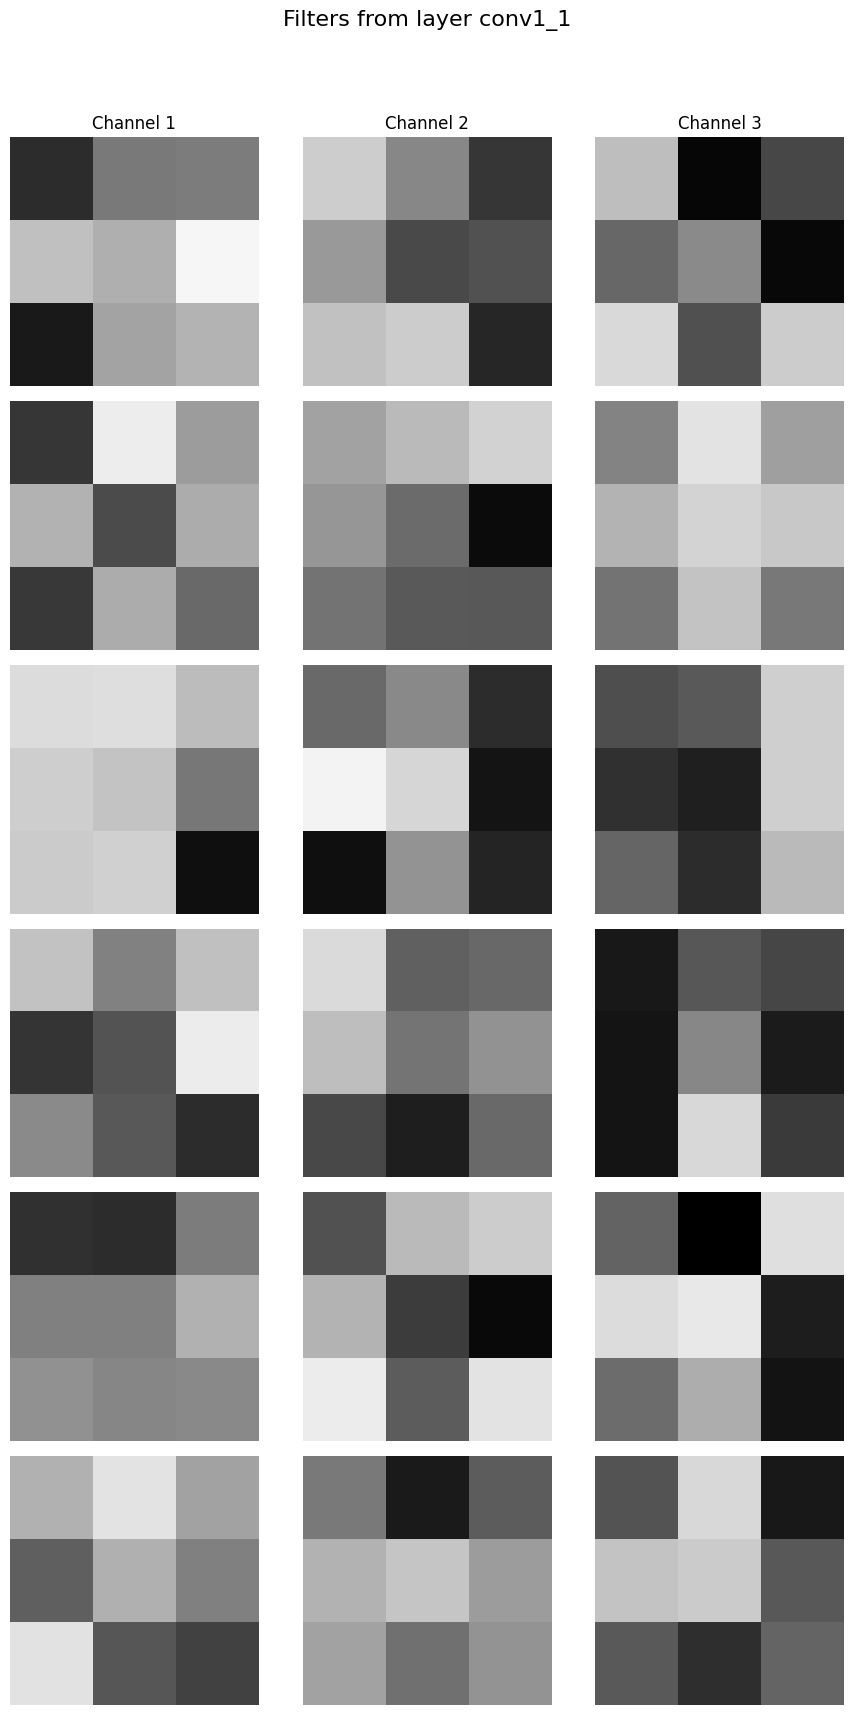

In [ ]:
def visualize_filters_per_channel(layer, layer_name, num_filters=10):
    """
    Visualise chaque filtre d'une couche convolutive par canal, en niveaux de gris.
    Affiche chaque filtre en ligne, avec les canaux (R, G, B) en colonne.
    """
    # Récupération des poids de la couche (shape: [out_channels, in_channels, height, width])
    filters = layer.weight.data.cpu().numpy()

    # Nombre de filtres à afficher (limité à num_filters)
    num_filters = min(num_filters, filters.shape[0])
    num_channels = filters.shape[1]

    fig, axes = plt.subplots(num_filters, num_channels, figsize=(3 * num_channels, 3 * num_filters))
    fig.suptitle(f'Filters from layer {layer_name}', fontsize=16)

    # Affichage des filtres, chaque ligne représente un filtre, chaque colonne un canal (R, G, B)
    for i in range(num_filters):
        for j in range(num_channels):
            ax = axes[i, j] if num_filters > 1 else axes[j]  # Handle case where num_filters=1
            filter_img = filters[i, j, :, :]

            ax.imshow(filter_img, cmap='gray', vmin=filters.min(), vmax=filters.max())
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Channel {j+1}', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualisation des filtres de la première couche, par exemple, les 6 premiers filtres
visualize_filters_per_channel(model.conv1_1, "conv1_1", num_filters=6)

# Horia-Rares, Vulcu: Evaluation & Testing Lead

In [ ]:
!pip install onnxscript
def export(export_path = './models/cat_or_dog.onnx'):
    warnings.filterwarnings('default')
    if not os.path.exists('./models'):
        os.makedirs('./models')

    X, y = get_random_samples(train_dataset, 1)
    input_tensor = X[0].unsqueeze(0).to(device)

    torch.onnx.export(model,                      #model being run
                      input_tensor,               #model input
                      export_path,                #where to save the model
                      input_names = ['input'],    #the models input names
                      output_names = ['output'])  #the models output names
    warnings.filterwarnings('ignore')

export()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 19.3 MB/s eta 0:00:00


W0208 15:20:39.816000 644 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
W0208 15:20:39.820000 644 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0208 15:20:39.823000 644 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, outpu

[torch.onnx] Obtain model graph for `CNNBinaryClassifier([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `CNNBinaryClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
warnings.filterwarnings('ignore')

graphviz.set_jupyter_format('png')

'png'

In [ ]:
import_path = './models/cat_or_dog.onnx'

onnx_model = onnx.load(import_path)
onnx.checker.check_model(onnx_model)

In [ ]:
#set up the directory for storing false predictions
false_preds_dir = './false_preds'
if os.path.exists(false_preds_dir):
    shutil.rmtree(false_preds_dir)
os.makedirs(false_preds_dir)  #create directory for false predictions

#define the inverse transformation for RGB images
inverse_transform = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],  #undo normalization per channel
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    ),
    transforms.ToPILImage()#convert back to PIL image in RGB
])

In [ ]:
import numpy as np

#calculate F1 for every threshold point in your graph
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"The mathematically optimal threshold is: {best_threshold:.4f}")

The mathematically optimal threshold is: 0.1871


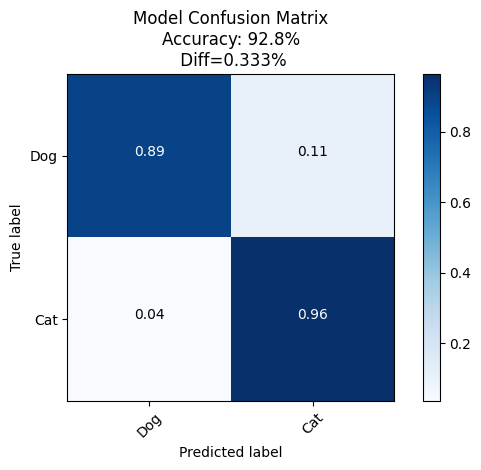

In [ ]:
new_threshold = 0.1871  #0.25 #0.40 #0.55 #0.75

#ONNX runtime session
ort_session = ort.InferenceSession(import_path)

#prediction scores and true labels
prediction_scores = []  #raw prediction scores (before threshold)
true_labels = []        #true binary labels (0 or 1)

idx = 0

#going over the test loader
for images, labels in test_loader:
    for image, label in zip(images, labels):

        image = image.unsqueeze(0).cpu() #move the image to the CPU and add a batch dimension

        #run inference on the image and get raw score
        outputs = ort_session.run(None, {'input': image.numpy()})
        score = outputs[0][0]  #probability or raw score for 'Cat' class

        #store the raw prediction score and the true label
        prediction_scores.append(score)
        true_label = label.cpu().detach().numpy().item()
        true_labels.append(true_label)

#calculate baseline accuracy using the PyTorch model and default threshold 0.5
accuracy, _ = validate_model(model, test_loader, threshold=0.5)

new_acc = sum((score[0] > new_threshold) == label for score, label in zip(prediction_scores, true_labels)) / len(prediction_scores)
cm = confusion_matrix(true_labels, [int(score > new_threshold) for score in prediction_scores], labels=[0, 1])

diff = abs(accuracy - new_acc)

plot_confusion_matrix(cm, classes=classes, title=f"Model Confusion Matrix\nAccuracy: {new_acc * 100:.1f}%\n Diff={diff * 100:.3f}%", normalize=True)

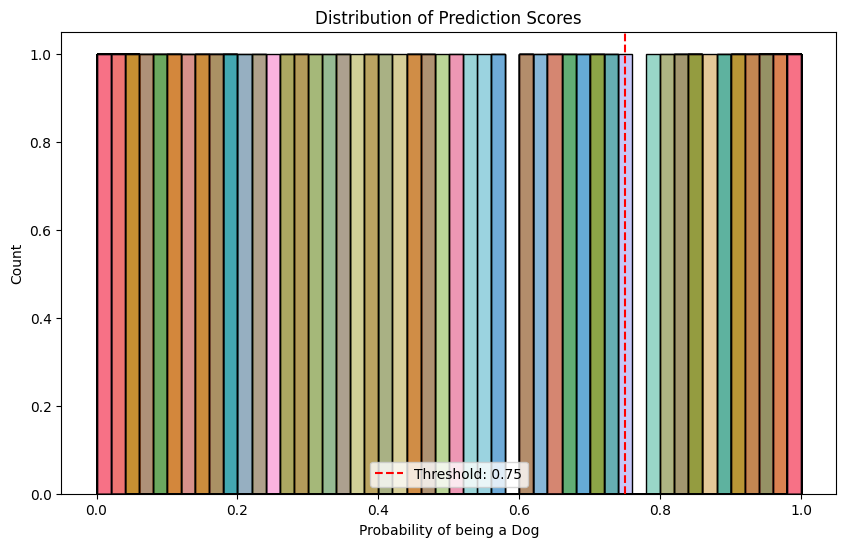

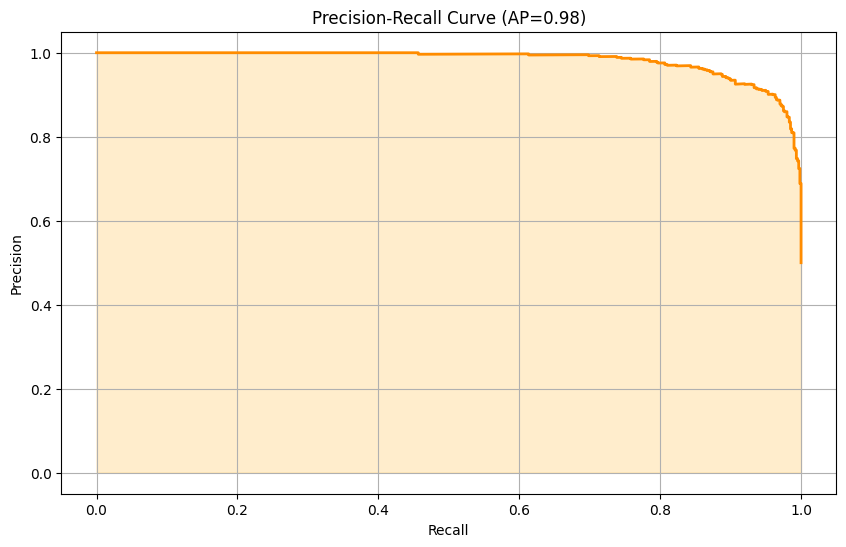

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns

#probability distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(prediction_scores, bins=50, kde=True, color='skyblue')
plt.axvline(new_threshold, color='red', linestyle='--', label=f'Threshold: {new_threshold}')
plt.title('Distribution of Prediction Scores')
plt.xlabel('Probability of being a Dog')
plt.ylabel('Count')
plt.legend()
plt.show()

#precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, prediction_scores)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={average_precision_score(true_labels, prediction_scores):.2f})')
plt.grid(True)
plt.show()

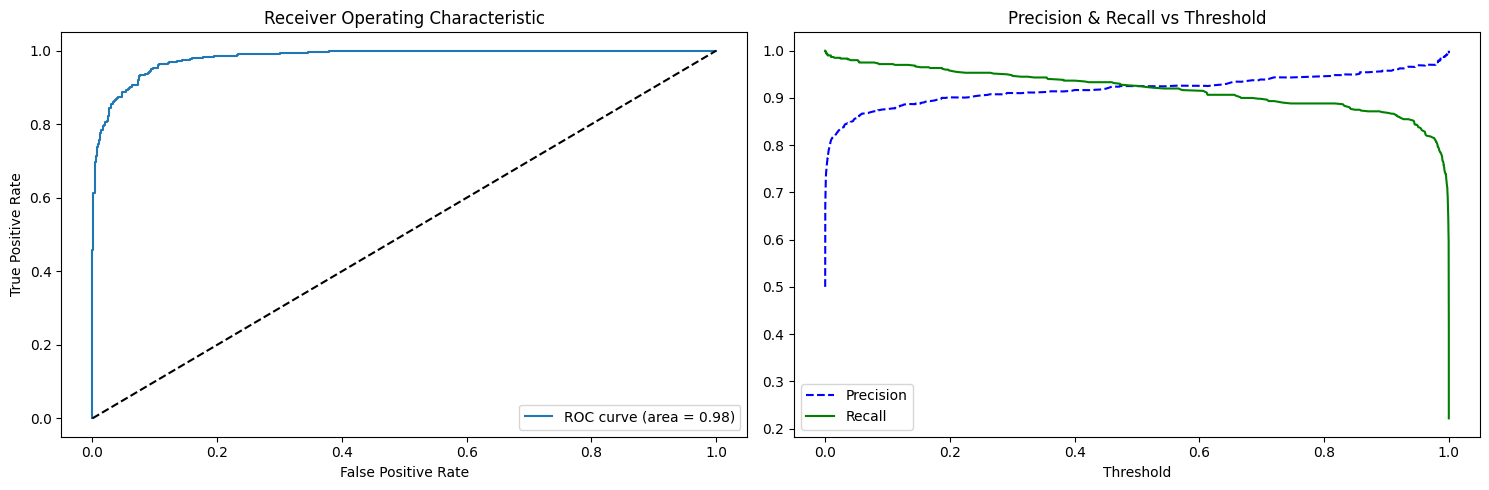

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

#calculate ROC Curve
fpr, tpr, _ = roc_curve(true_labels, prediction_scores)
roc_auc = auc(fpr, tpr)

#calculate Precision-Recall for Threshold Analysis
precisions, recalls, thresholds = precision_recall_curve(true_labels, prediction_scores)

plt.figure(figsize=(15, 5))

#plot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

#plot precision-recall vs threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title('Precision & Recall vs Threshold')
plt.xlabel('Threshold')
plt.legend()

plt.tight_layout()
plt.show()

Total misclassified at optimal threshold: 86


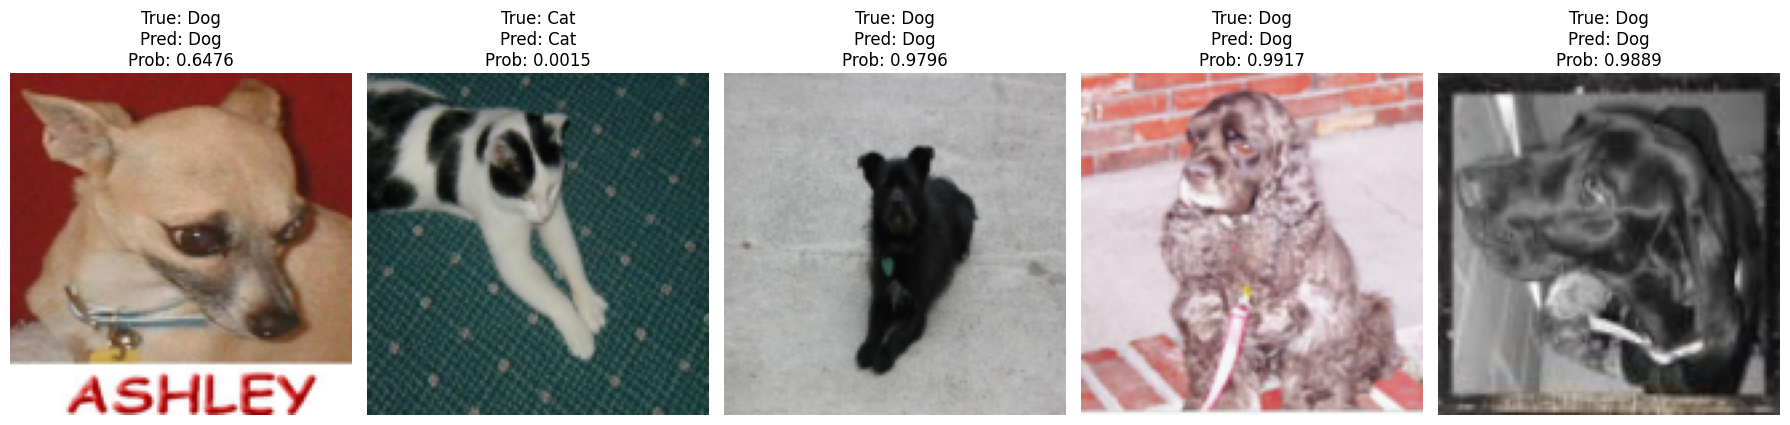

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#identify misclassified indices
#.item() to compare scalars
misclassified_indices = [
    i for i, (p, t) in enumerate(zip(prediction_scores, true_labels))
    if (float(p) > 0.1871) != t
]

print(f"Total misclassified at optimal threshold: {len(misclassified_indices)}")

#visualize the "Top 5" errors
plt.figure(figsize=(18, 5))
for i, idx in enumerate(misclassified_indices[:5]):
    #get the image and label from your dataset
    image, label = test_dataset[idx]

    #convert the normalized tensor back to a viewable PIL image
    image_pil = inverse_transform(image)

    plt.subplot(1, 5, i+1)
    plt.imshow(image_pil)

    #.item() to convert the numpy score to a float for the f-string
    score_val = prediction_scores[idx]
    if isinstance(score_val, np.ndarray):
        score_val = score_val.item()

    plt.title(f"True: {classes[label]}\nPred: {'Dog' if score_val > 0.1871 else 'Cat'}\nProb: {score_val:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Amin, Moamen Tarek: Documentation, Report & Presentation Lead
